In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_color_codes()

### Grid approximation

- You toss a coin and you get `HTHHHTHTH` what are the posteriors (i.e. posterior beliefs)?
- Assume uniform prior
- Use the grid approximation to derive the result

Let's first define bias as Probability of Heads, $P(H)$. Let's assume that our prior belief about the bias of the coin is Uniform.

In [3]:
bias_grid = np.linspace(0, 1, 1000)
prior = np.repeat(1/len(bias_grid), len(bias_grid))

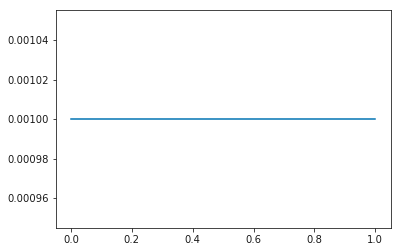

In [4]:
plt.plot(bias_grid, prior)

The above chart can be read as, we have a uniform prior belief that the true bias of the coin can be anywhere between 0 and 1.

Now let's consider the likelihood. Assuming our prior belief is that the true
probability of water is `p`, what is the likelihood that `k` trials are 
successful (i.e. result in water). 

In [8]:
def likelihood_func(n, k, bias_grid):
    """Returns an array, normalized likelihoods, 
    where likelihoods[i] is the likelihood of getting 
    k successes in n trials where probability of success 
    in one trial is belief[i].
    """
    lk = stats.binom.pmf(k, n, bias_grid)
    # Note that lk.sum() doesn't have to be 1!
    # Note that we are keeping k fixed and varying `p`. 
    # The case you're probably thinking of is keeping
    # `p` fixed and varying k in [0, n].
    return lk/lk.sum()

In [7]:
likelihoods_6_of_9 = likelihood_func(9, 6, bias_grid)

In [6]:
def plot_likelihood(lk):
    fig, ax = plt.subplots()
    plt.plot(beliefs, lk)
    plt.xlabel('belief')
    plt.ylabel('Likelihood\nP(6 successes in 9 trials)\ngiven our "belief" is\nP(success) in one trial')

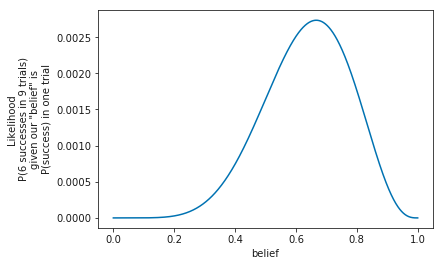

In [7]:
plot_likelihood(likelihoods_6_of_9)

In [10]:
def average_likelihood_func(prior, likelihood):
    return (prior * likelihood).sum()

def posterior_func(prior, likelihood_func, **kwargs):
    likelihood = likelihood_func(**kwargs)
    return (prior*likelihood)/average_likelihood_func(prior, likelihood)

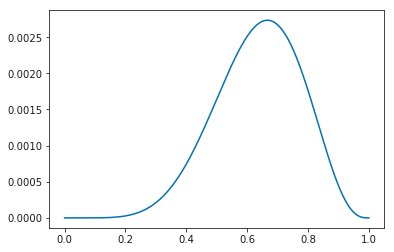

In [12]:
plt.plot(bias_grid, posterior_func(prior, likelihood_func, n=9, k=6, bias_grid=bias_grid))

Note that this peaks around 0.66 or 6/9 which makes sense since our _posterior belief_ after 6 out of 9 success should be centered around 6/9 and will decrease as we move farther away.

Now let's solve the actual problem at hand. Posteriors after each trial of `WLWWWLWLW`

In [19]:
outcomes = 'HTHHHTHTH'

successes = lambda outcomes: outcomes.count('H')
trials = lambda outcomes: len(outcomes)

def run_multiple_trials(outcomes, grid, first_prior):
    priors = [first_prior]
    for i in range(len(outcomes)):
        p = posterior_func(
            priors[0],
            likelihood_func,
            n=trials(outcomes[:i+1]),
            k=successes(outcomes[:i+1]),
            bias_grid=bias_grid)
        priors.append(p)
    return priors

In [20]:
priors = run_multiple_trials(outcomes, bias_grid, prior)

In [25]:
def plot_beliefs_priors(grid, priors):
    fig, ax = plt.subplots(3, 3, sharex='all', sharey='all')
    for i in range(9):
        ax[i//3][i%3].plot(grid, priors[i], linestyle='dashed')
        ax[i//3][i%3].plot(grid, priors[i+1])

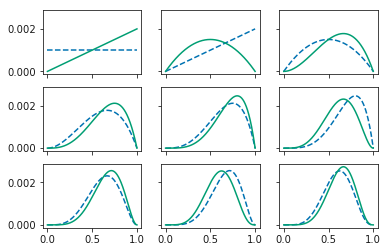

In [26]:
plot_beliefs_priors(bias_grid, priors)

In [33]:
bias_grid[np.argmax(priors[-1])]

0.66666666666666663

### Qudaratic approximation

In [28]:
with pm.Model() as coin_model:
    observed = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1])
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=len(observed), p=p, observed=observed.sum())
    mean_q = pm.find_MAP()
    h = pm.find_hessian(mean_q)

//anaconda/envs/resample/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 2.779483
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


In [29]:
mean_q, h

({'p_interval_': array(0.5596160976112581)}, array([[ 2.54545433]]))